In [1]:
import os
import sys

script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

In [2]:
class ECGDataAugmentation:
    def __init__(self, noise_level=0.01, shift_range=0.1, mask_prob=0.1):
        """
        Аргументы:
        noise_level (float): Уровень шума, добавляемого к сигналу.
        shift_range (float): Максимальный сдвиг сигнала, выраженный в доле от длины.
        mask_prob (float): Вероятность маскирования случайных интервалов.
        """
        self.noise_level = noise_level
        self.shift_range = shift_range
        self.mask_prob = mask_prob

    def add_noise(self, signal):
        """Добавляем гауссовский шум к сигналу."""
        noise = torch.randn_like(signal) * self.noise_level
        return signal + noise

    def shift_signal(self, signal):
        """Сдвигаем сигнал на случайное значение в пределах shift_range."""
        shift_amount = int(self.shift_range * signal.size(-1))
        shift = np.random.randint(-shift_amount, shift_amount)
        return torch.roll(signal, shifts=shift, dims=-1)

    def mask_random_intervals(self, signal):
        """Маскируем случайные интервалы в сигнале, заменяя их на нули."""
        mask = torch.rand(signal.size()) < self.mask_prob
        signal = signal.masked_fill(mask, 0)
        return signal

    def __call__(self, signal):
        """Применяем все аугментации."""
        signal = self.add_noise(signal)
        signal = self.shift_signal(signal)
        signal = self.mask_random_intervals(signal)
        return signal
    
data_augmentation = ECGDataAugmentation(noise_level=0.01, shift_range=0.1, mask_prob=0.1)

In [3]:
# Примерная функция для нормализации
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Класс для подготовки датасета
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.fixed_length = 5000  # Пример длины для padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Берем данные пациента
        ecg_signal = self.data[idx]
        
        # Применяем нормализацию к каждому каналу
        ecg_signal = np.array([normalize(ch) for ch in ecg_signal])
        
        # Padding/Truncation до фиксированной длины
        ecg_signal = self._fix_length(ecg_signal)
        
        # Преобразование в torch.tensor
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return ecg_signal, label
    
    def _fix_length(self, ecg_signal):
        # Применяем padding или обрезание
        if ecg_signal.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - ecg_signal.shape[1]
            ecg_signal = np.pad(ecg_signal, ((0, 0), (0, pad_size)), 'constant')
        else:
            ecg_signal = ecg_signal[:, :self.fixed_length]
        return ecg_signal

def create_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(labels), replacement=True)
    return sampler

import pickle
with open('../../Data/dumped/X_train.pkl', 'rb') as f:
    f.seek(0)
    X_train = pickle.load(f)
with open('../../Data/dumped/y_train.pkl', 'rb') as f:
    f.seek(0)
    y_train = pickle.load(f)
with open('../../Data/dumped/X_test.pkl', 'rb') as f:
    f.seek(0)
    X_test = pickle.load(f)
with open('../../Data/dumped/y_test.pkl', 'rb') as f:
    f.seek(0)
    y_test = pickle.load(f)
    
print(X_train.shape)
print(y_train.shape)
y_train = np.concatenate([y_train, y_train], axis=1)
Y_train = y_train[0].astype('int8')
Y_test = y_test[0].astype('int8')
# Y_train = F.one_hot(torch.LongTensor(y_train[0]), num_classes=2).double()
# Y_train.double()
# Y_test = F.one_hot(torch.LongTensor(y_test[0]), num_classes=2).double()
# Y_test.double()
# Y_train = y_train[0]
# Y_test = y_test[0]


X_train = np.concatenate([X_train, np.array([data_augmentation(torch.tensor(x)).numpy() for x in X_train])], axis=0)
print(X_train.shape)
print(y_train.shape)

sampler = create_weighted_sampler(torch.LongTensor(Y_train))
train_dataset = ECGDataset(data=X_train, labels=Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
# train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = ECGDataset(data=X_test, labels=Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



(132, 8, 5000)
(2, 132)
(264, 8, 5000)
(2, 264)


In [4]:
import torch.nn as nn

class ECGNet(nn.Module):
    def __init__(self):
        super(ECGNet, self).__init__()
        
        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # LSTM слой для захвата временных зависимостей
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=2, batch_first=True, bidirectional=True)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(64*2, 128)
        self.fc2 = nn.Linear(128, 3)  # Предполагается 3 класса болезней
        
    def forward(self, x):
        # x shape: [batch_size, 8, seq_len]
        
        # Свертка
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Подготовка для LSTM
        # Меняем размер на [batch_size, seq_len, channels] для LSTM
        x = x.permute(0, 2, 1)
        
        # LSTM
        x, (hn, cn) = self.lstm(x)
        
        # Берем последнее скрытое состояние LSTM
        x = x[:, -1, :]  # [batch_size, 64*2]
        
        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # [batch_size, num_classes]
        
        return x

In [5]:

class MultiBranchECGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3):
        super(MultiBranchECGNet, self).__init__()
        
        # Ветви для каждого канала (CNN)
        self.branches = nn.ModuleList([self.create_branch() for _ in range(num_channels)])
        
        # Attention слой для агрегации информации между каналами
        self.attention = nn.MultiheadAttention(embed_dim=128, num_heads=8, batch_first=True)
        
        # Линейный слой для выравнивания размерности перед attention
        self.linear_attn = nn.Linear(num_channels * 128, 128)
        
        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(p=0.5)
    
    def create_branch(self):
        """Создаем сверточную ветвь для каждого канала"""
        branch = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),  # Свертка с padding
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # Вторая сверточная операция
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  # Третья сверточная операция
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        return branch
    
    def forward(self, x):
        # x shape: [batch_size, num_channels, seq_len]
        
        # Обрабатываем каждый канал через свою ветвь (CNN для каждого канала)
        branch_outputs = []
        for i in range(x.size(1)):  # num_channels
            branch_output = self.branches[i](x[:, i:i+1, :])  # Обрабатываем i-й канал, [batch_size, 1, seq_len]
            branch_outputs.append(branch_output)
        
        # Объединяем выходы ветвей
        out = torch.stack(branch_outputs, dim=1)  # [batch_size, num_channels, 128, reduced_seq_len]
        
        # out = out.mean(dim=-1)  # Усредняем по временной оси: [batch_size, num_channels, 128]
        
        # # Применяем multi-head attention для межканальной агрегации
        # out, _ = self.attention(out, out, out)  # [batch_size, num_channels, 128]
        
        # # Flatten the output
        # out = torch.flatten(out, start_dim=1, end_dim=2)  # [batch_size, num_channels * 128]
        
         # Меняем форму, чтобы соответствовать входу MultiheadAttention: [batch_size, reduced_seq_len, num_channels * 128]
        batch_size, num_channels, embed_dim, seq_len = out.shape
        out = out.permute(0, 3, 1, 2).reshape(batch_size, seq_len, -1)
        
        out = F.relu(self.linear_attn(out))
        
        # Применяем Multihead Attention ко всей последовательности
        out, _ = self.attention(out, out, out)  # [batch_size, seq_len, num_channels * 128]
        
        # Усредняем по временной оси
        out = out.mean(dim=1)  # [batch_size, num_channels * 128]
        
        # Полносвязные слои для классификации
        out = F.relu(self.drop(self.fc1(out)))
        out = self.fc2(out)  # [batch_size, num_classes]
        return out

# Пример использования
model = MultiBranchECGNet(num_channels=8, num_classes=2)


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
pos_weight = torch.tensor([1, 2])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = FocalLoss(alpha=2, gamma=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Обучение модели
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, patience=10):
    best_valid_loss = float('inf')
    patience_counter = 0
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # labels.type(torch.FloatTensor)

            # labels = labels.type(torch.FloatTensor) \
                #   .reshape((labels.shape[0], 2))
                
            labels = F.one_hot(labels, num_classes=2).float()
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        # if epoch_loss < best_valid_loss:
        #     best_valid_loss = epoch_loss
        #     patience_counter = 0
        # else:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         print("Early stopping triggered")
        #         break
        if epoch_loss < best_valid_loss:
            best_valid_loss = epoch_loss
            print(f"\nBest validation loss: {best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model, 'best_model.pt')
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Запуск обучения
train_model(model, train_loader, criterion, optimizer,  num_epochs=80)


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Best validation loss: 0.8207401687448675

Saving best model for epoch: 1

Epoch 1/80, Loss: 0.8207

Best validation loss: 0.7383676279674877

Saving best model for epoch: 2

Epoch 2/80, Loss: 0.7384


/tmp/ipykernel_3809318/2220220472.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pt')


Validation recall: 0.8750
Validation accuracy: 0.8125
Validation precision: 0.4667

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.80      0.88        40
           1       0.47      0.88      0.61         8

    accuracy                           0.81        48
   macro avg       0.72      0.84      0.74        48
weighted avg       0.89      0.81      0.83        48

Матрица несоответствий для тестовой выборки метода ЛДА:



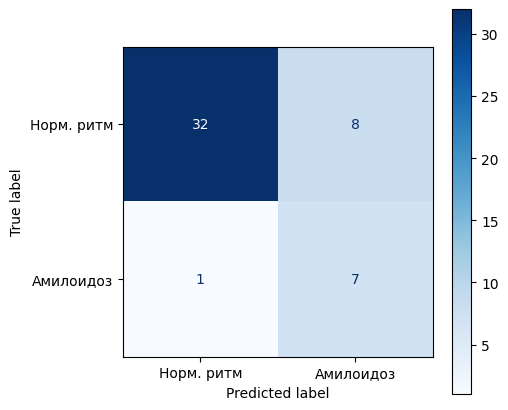

In [ ]:
from sklearn.metrics import recall_score, accuracy_score, precision_score

def validate_model(model, dataloader):
    model = MultiBranchECGNet(num_channels=8, num_classes=2)
    model = torch.load('best_model.pt')
    # model.eval()
    model.eval()  # Переводим модель в режим оценки
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Отключаем градиенты для валидации
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Предсказания с максимальной вероятностью
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Преобразуем в numpy массивы
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    # all_labels = np.argmax(all_labels, axis=1)
    
    # Считаем accuracy
    recall = recall_score(all_labels, all_preds)
    print(f'Validation recall: {recall:.4f}')
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Validation accuracy: {accuracy:.4f}')
    precision = precision_score(all_labels, all_preds)
    print(f'Validation precision: {precision:.4f}')

    class_names = ['Норм. ритм', 'Амилоидоз']

    print ('\n clasification report:\n', classification_report(all_labels, all_preds))

    print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix(all_labels, all_preds), display_labels= class_names)
    disp.plot(cmap = 'Blues', ax=ax)
    
    return recall

# Пример вызова валидации
test_accuracy = validate_model(model, test_loader)
